# Groundnut Leaf Disease Detection Project

# Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import ParameterGrid

# Set Dataset Path

In [2]:
dataset_path = r"E:\A\OneDrive\Documents\3rd year\5th SEM Materials of SR.Mishra(3rd yr)\Deep Learning for Image Analytics\Project\Groundnut_Leaf_dataset\Main Used Dataset"

img_size = (224, 224)
batch_size = 32

# Data Preprocessing

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

num_classes = len(train_gen.class_indices)

Found 6329 images belonging to 6 classes.
Found 1581 images belonging to 6 classes.


# Helper Function — Build Model

In [4]:
def build_mobilenet_model(lr=1e-4, dropout_rate=0.3):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# Hyperparameter Tuning (Manual Grid Search)

In [5]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

param_grid = {
    'lr': [1e-4, 5e-4],
    'dropout_rate': [0.3],
    'batch_size': [16, 32]
}

best_acc = 0
best_params = {}
best_model = None
best_history = None  # ✅ new variable to store best training history

for params in ParameterGrid(param_grid):
    print(f"\n🔍 Testing Params: {params}")
    model = build_mobilenet_model(lr=params['lr'], dropout_rate=params['dropout_rate'])

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,   # ✅ reduced epochs (runs faster)
        batch_size=params['batch_size'],
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=1, min_lr=1e-6)
        ],
        verbose=1
    )

    val_acc = max(history.history['val_accuracy'])
    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params
        best_model = model
        best_history = history   # ✅ store best model’s training history

print("\n✅ Best Hyperparameters:")
print(best_params)
print(f"Validation Accuracy: {best_acc:.4f}")


🔍 Testing Params: {'batch_size': 16, 'dropout_rate': 0.3, 'lr': 0.0001}


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 181s 887ms/step - accuracy: 0.3413 - loss: 1.6668 - val_accuracy: 0.5376 - val_loss: 1.2357 - learning_rate: 1.0000e-04
Epoch 2/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 175s 883ms/step - accuracy: 0.5609 - loss: 1.1451 - val_accuracy: 0.6483 - val_loss: 1.0117 - learning_rate: 1.0000e-04
Epoch 3/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 175s 885ms/step - accuracy: 0.6606 - loss: 0.9111 - val_accuracy: 0.7141 - val_loss: 0.8804 - learning_rate: 1.0000e-04
Epoch 4/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 172s 868ms/step - accuracy: 0.6995 - loss: 0.8023 - val_accuracy: 0.7217 - val_loss: 0.8376 - learning_rate: 1.0000e-04
Epoch 5/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 171s 866ms/step - accuracy: 0.7320 - loss: 0.7266 - val_accuracy: 0.7381 - val_loss: 0.7717 - learning_rate: 1.0000e-04

🔍 Testing Params: {'batch_size': 16, 'dropout_rate': 0.3, 'lr': 0.0005}
Epoch 1/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.5949 - loss: 1.0887 - val_accuracy: 0.7299 - val_loss: 0.8379 - le

# Evaluation

In [6]:
loss, acc = best_model.evaluate(val_gen)
print(f"\nFinal Validation Accuracy: {acc*100:.2f}%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8280 - loss: 0.5859

Final Validation Accuracy: 82.80%


# Save the Best Model

In [8]:
model_save_path = "best_groundnut_model.h5"
best_model.save(model_save_path)
print(f"\n Model saved to: {model_save_path}")


 Model saved to: best_groundnut_model.h5


# Results — Visualize Accuracy and Loss

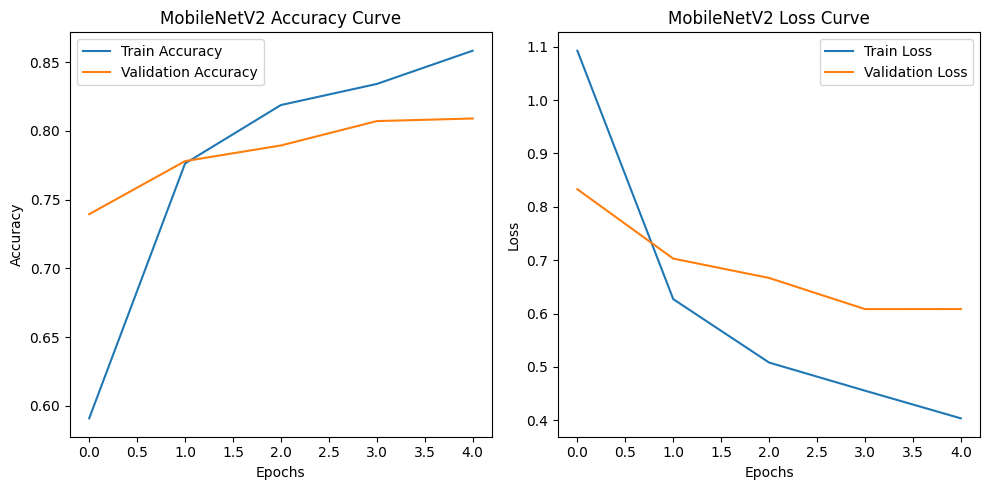

In [10]:
plt.figure(figsize=(10,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("MobileNetV2 Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("MobileNetV2 Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on a Single New Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


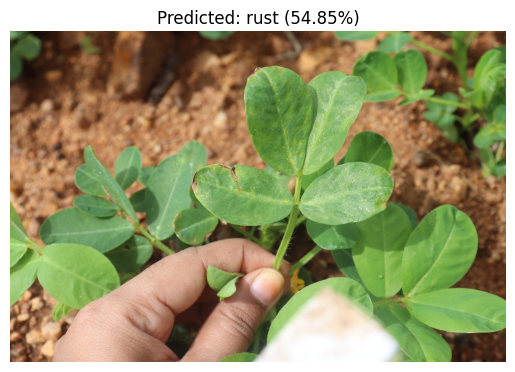

✅ Predicted Disease: rust (54.85%)


In [15]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
import numpy as np
import matplotlib.pyplot as plt

# Correct image path from your Raw_Data folder
img_path = r"E:\A\OneDrive\Documents\3rd year\5th SEM Materials of SR.Mishra(3rd yr)\Deep Learning for Image Analytics\Project\Groundnut_Leaf_dataset\Raw_Data(original dataset)\early_leaf_spot\IMG_0325.JPG"

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = mobilenet_preprocess(img_array)  # Preprocess for MobileNetV2

# Predict using the trained best model
prediction = best_model.predict(img_array)
predicted_class = list(train_gen.class_indices.keys())[np.argmax(prediction)]
confidence = np.max(prediction) * 100

# Display the image with predicted label
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
plt.axis("off")
plt.show()

print(f"✅ Predicted Disease: {predicted_class} ({confidence:.2f}%)")

# Testing With Multiple Images

Found 30 images in total.


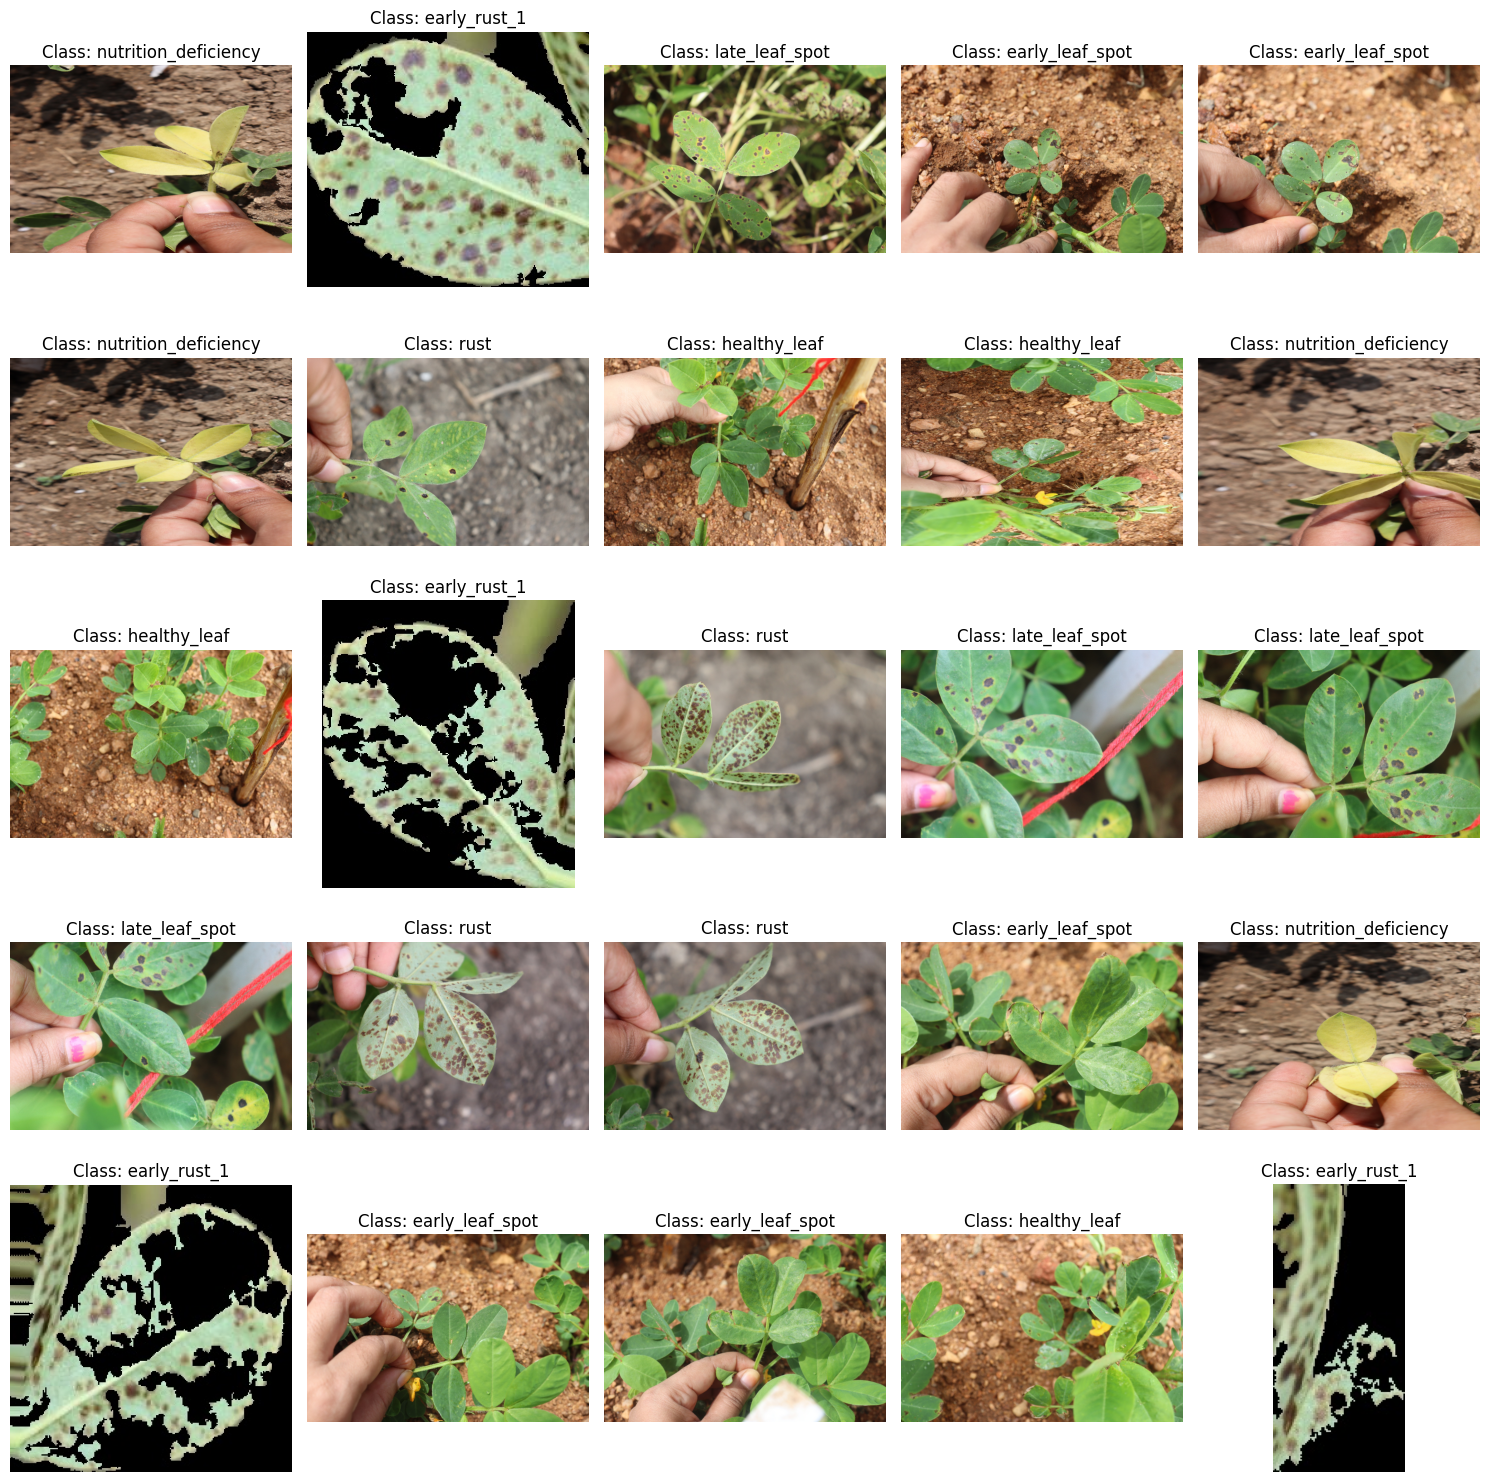

In [16]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your main testing dataset folder
test_dir = r"E:\A\OneDrive\Documents\3rd year\5th SEM Materials of SR.Mishra(3rd yr)\Deep Learning for Image Analytics\Project\Groundnut_Leaf_dataset\Testing Dataset"

# --- 1. Find all image files ---
image_files = []
# Walk through all folders and subfolders
for root, dirs, files in os.walk(test_dir):
    for file in files:
        # Check for common image extensions
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} images in total.")

# --- 2. Select a random sample ---
num_to_show = 25
# Ensure we don't try to sample more images than we found
num_to_show = min(num_to_show, len(image_files)) 

if num_to_show == 0:
    print("No images found in the directory.")
else:
    random_images = random.sample(image_files, num_to_show)

    # --- 3. Plot the images ---
    # Calculate grid size (e.g., 5x5 for 25 images)
    grid_size = int(num_to_show**0.5) + (1 if num_to_show**0.5 % 1 else 0)
    
    plt.figure(figsize=(15, 15))
    
    for i, img_path in enumerate(random_images):
        img = mpimg.imread(img_path)
        
        # Get the class name (which is the parent folder's name)
        class_name = os.path.basename(os.path.dirname(img_path))
        
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {class_name}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()